In [1]:
!pip install -U setuptools

  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-78.1.0-py3-none-any.whl (1.3 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 78.0.2
    Uninstalling setuptools-78.0.2:
      Successfully uninstalled setuptools-78.0.2


In [2]:
import triton

In [11]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoConfig,
)
import transformers

from datasets import load_dataset
from composer import Trainer    
from composer.models import HuggingFaceModel, ComposerModel

import torch
from torch.utils.data import DataLoader

model_name = "roneneldan/TinyStories-1M"
config = AutoConfig.from_pretrained(model_name)
config.max_position_embeddings = 512
model = AutoModelForCausalLM.from_config(config, attn_implementation='flash_attention_2', torch_dtype=torch.bfloat16).to('cuda')
sum(p.numel() for p in model.parameters() if p.requires_grad)

3647680

In [13]:
max_vocab_size = 2048

In [14]:
train_data = load_dataset('roneneldan/TinyStories', split='train').with_format('np')
val_data = load_dataset('roneneldan/TinyStories', split='validation').with_format('np')

README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [15]:
def get_training_corpus():
    for start_idx in range(0, len(train_data), 10000):
        patch = train_data[start_idx: start_idx+10000]
        yield patch['text']
        

In [16]:
corpus = get_training_corpus()
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [17]:
# tokenizer = tokenizer.train_new_from_iterator(corpus, vocab_size=max_vocab_size)
# tokenizer.save_pretrained(f'./training/tokenizer/{max_vocab_size}')

In [18]:
tokenizer = tokenizer.from_pretrained(f'./training/tokenizer/{max_vocab_size}')

In [19]:
model.resize_token_embeddings(tokenizer.vocab_size)

Embedding(2048, 64)

In [20]:
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): GPTNeoForCausalLM(
    (transformer): GPTNeoModel(
      (wte): Embedding(2048, 64)
      (wpe): Embedding(512, 64)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPTNeoBlock(
          (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): GPTNeoAttention(
            (attention): GPTNeoFlashAttention2(
              (attn_dropout): Dropout(p=0.0, inplace=False)
              (resid_dropout): Dropout(p=0.0, inplace=False)
              (k_proj): Linear(in_features=64, out_features=64, bias=False)
              (v_proj): Linear(in_features=64, out_features=64, bias=False)
              (q_proj): Linear(in_features=64, out_features=64, bias=False)
              (out_proj): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mlp): GPTNeoMLP(
            (c_fc): Linear(in_features=64, out_f

In [21]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

562304

In [22]:
def tokenize(e):
    # return {'tokens': tokenizer.tokenize(e['text'])}
    return tokenizer(e['text'], truncation=True, max_length=512, padding='max_length', return_attention_mask=False)

tokenizer.pad_token = tokenizer.eos_token
# tok_train = train_data.map(tokenize, remove_columns=['text'], num_proc=8)
# tok_val  = val_data.select(range(1000)).map(tokenize, remove_columns=['text'], num_proc=8)

In [23]:
max_len = 10
max_pos = []
max_token = []
for k, v in tokenizer.vocab.items():
    if len(k) > max_len:
        max_pos.append(v)
        max_token.append(k)

max_token, max_len, max_pos

(['Ġadventures',
  'Ġremembered',
  '<|endoftext|>',
  'Ġeverywhere',
  'Ġunderstand',
  'Ġeverything'],
 10,
 [1906, 1405, 0, 1757, 1454, 1601])

In [14]:
# !rm -rf ./datasets/tinystories/2048

In [24]:
from streaming import MDSWriter
import numpy as np

out_root = f'./datasets/tinystories/{tokenizer.vocab_size}/'
out_train = out_root + 'train/'
out_val = out_root + 'val/'

columns = {
    'input_ids': 'ndarray:int32',
    # 'attention_mask': 'ndarray:int64',
}
# with MDSWriter(out=out_train, columns=columns, compression='zstd') as writer:
#     for sample in tok_train:
#         sample['input_ids'] = sample['input_ids'].astype(np.int32)
#         writer.write(sample)

# with MDSWriter(out=out_val, columns=columns, compression='zstd') as writer:
#     for sample in tok_val:
#         sample['input_ids'] = sample['input_ids'].astype(np.int32)
#         writer.write(sample)

In [25]:
from streaming import StreamingDataset
bs = 128
tok_train = StreamingDataset(local=out_train, shuffle=True, shuffle_seed=42, batch_size=bs)
tok_val = StreamingDataset(local=out_val, batch_size=bs)

In [26]:
tok_train[0].keys()

dict_keys(['input_ids'])

In [28]:
len(tok_train)

2119719

In [34]:
len(tok_train) - count

1168391

In [36]:
count = 0
for ex in tok_train[:len(tok_train)]:
    if 0 not in ex['input_ids']:
        count +=1 

count

100786

In [18]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(e['input_ids']).to('cuda').to(torch.int64) for e in batch])
    # masks = torch.stack([torch.tensor(e['attention_mask']).to('cuda') for e in batch])
    labels = torch.stack([torch.tensor(e['input_ids']).to('cuda').to(torch.int64) for e in batch])
    return {
        'input_ids': input_ids,
        # 'attention_mask': masks,
        'labels': labels,
        # 'inputs_embeds': None
    }

In [19]:
collator = collate_fn

torch.random.manual_seed(42)
dl_train = DataLoader(tok_train, batch_size=bs, collate_fn=collator)
dl_val = DataLoader(tok_val, batch_size=bs, shuffle=False, collate_fn=collator)

In [20]:
len(dl_train)

16561

In [21]:
class MyModel(HuggingFaceModel):
    def __init__(self, model, tokenizer, metrics=[], use_logits=False):
        super().__init__(model, tokenizer, metrics=metrics, use_logits=use_logits)

    def forward(self, batch):
        return self.model(**batch)
    
    def loss(self, outputs, batch):
        return outputs.loss

In [22]:
batch = next(iter(dl_train))

In [23]:
tokenizer.batch_decode(batch['input_ids'][:2])

['Tim and Sue are friends who live on a farm. They like to play with the animals in the barn. One day, they see a big truck coming to the farm. The truck has many boxes and tools.\n\n"What is that?" Tim asks.\n\n"I don\'t know. Let\'s go and see," Sue says.\n\nThey run to the truck and see a man talking to Tim\'s dad. The man says he is here to make the barn bigger. He says he will increase the size of the barn and add more rooms for the animals.\n\n"Why do you need a bigger barn?" Sue asks.\n\n"Because we have more animals now. We have cows, pigs, chickens, horses, and sheep. They need more space and comfort," Tim\'s dad says.\n\n"Can we help you?" Tim asks.\n\n"Sure, you can help me by staying out of the way and being careful. This work is harsh and dangerous. You don\'t want to get hurt by the tools or the boxes," the man says.\n\n"OK, we will be careful. Can we watch you work?" Sue asks.\n\n"Yes, you can watch from a safe distance. But don\'t touch anything, OK?" the man says.\n\n"

In [24]:
from torchmetrics.classification import MulticlassAccuracy
from composer.models.huggingface import HuggingFaceModel
from composer.metrics import CrossEntropy, MaskedAccuracy, LanguageCrossEntropy

metrics = [MaskedAccuracy(ignore_index=0)]
# Package as a trainer-friendly Composer model
my_model = MyModel(model, tokenizer, metrics=metrics, use_logits=True)

In [25]:
from composer import Evaluator
eval_evaluator = Evaluator(
    label='acc',
    dataloader=dl_val,
    metric_names=['LanguageCrossEntropy', 'MaskedAccuracy'],
    device_eval_microbatch_size='auto'
)

/usr/lib/python3/dist-packages/composer/core/evaluator.py:147: UserWarning: Setting `device_eval_microbatch_size='auto'` is an experimental feature which may cause uncaught Cuda Out of Memory errors. In this case, please manually set device_eval_microbatch_size explicitly to an integer instead.
  warnings.warn((


In [26]:
from composer.optim import DecoupledAdamW, CosineAnnealingWithWarmupScheduler
from composer.loggers import InMemoryLogger
from composer.metrics import MaskedAccuracy

optim = DecoupledAdamW(my_model.parameters(), lr=2e-4, weight_decay=0.0001)
lr_scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='200ba', t_max="1dur")

logger = InMemoryLogger()

trainer = Trainer(
    model=my_model,
    train_dataloader=dl_train, 
    eval_dataloader=dl_val,
    optimizers=optim,
    schedulers=lr_scheduler,
    max_duration="100ba",
    eval_interval='1ba',
    save_folder="training/pretrain/33M/" + str(optim.param_groups[0]['lr']),
    save_interval="5000ba",
    # save_filename="hf_model.pt",
    save_overwrite=True,
    device_train_microbatch_size='auto',
    loggers=logger,
    device='gpu',
    precision='amp_bf16',
)

/usr/lib/python3/dist-packages/composer/trainer/trainer.py:247: UserWarning: `device_train_microbatch_size='auto'` may potentially fail with unexpected CUDA errors. Auto microbatching attempts to catch CUDA Out of Memory errors and adjust the batch size, but it is possible CUDA will be put into an irrecoverable state due to PyTorch bugs, e.g. integer overflow. In this case, please manually set device_train_microbatch_size explicitly to an integer instead.
  warnings.warn((


In [27]:
import time
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
composer_commit_hash: None
composer_version: 0.30.0
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3475228174

******************************


train                           0%|| 0/100 [00:00<?, ?ba/s]         

W0414 15:57:20.695000 3864 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


eval           Batch      1:    0%|| 0/8 [00:00<?, ?ba/s]         

/usr/lib/python3/dist-packages/composer/core/data_spec.py:40: UserWarning: Cannot split tensor of length 104 into batches of size 128. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(


eval           Batch      2:    0%|| 0/8 [00:00<?, ?ba/s]         

/usr/lib/python3/dist-packages/composer/core/data_spec.py:40: UserWarning: Cannot split tensor of length 104 into batches of size 128. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(


eval           Batch      3:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch      4:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch      5:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch      6:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch      7:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch      8:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch      9:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     10:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     11:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     12:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     13:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     14:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     15:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     16:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     17:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     18:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     19:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     20:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     21:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     22:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     23:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     24:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     25:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     26:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     27:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     28:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     29:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     30:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     31:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     32:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     33:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     34:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     35:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     36:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     37:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     38:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     39:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     40:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     41:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     42:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     43:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     44:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     45:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     46:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     47:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     48:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     49:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     50:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     51:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     52:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     53:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     54:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     55:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     56:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     57:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     58:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     59:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     60:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     61:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     62:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     63:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     64:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     65:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     66:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     67:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     68:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     69:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     70:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     71:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     72:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     73:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     74:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     75:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     76:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     77:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     78:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     79:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     80:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     81:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     82:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     83:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     84:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     85:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     86:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     87:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     88:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     89:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     90:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     91:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     92:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     93:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     94:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     95:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     96:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     97:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     98:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch     99:    0%|| 0/8 [00:00<?, ?ba/s]         

eval           Batch    100:    0%|| 0/8 [00:00<?, ?ba/s]         

It took 83.0117 seconds to train


In [42]:
logger.data.keys()

dict_keys(['time/epoch', 'time/batch', 'time/sample', 'time/batch_in_epoch', 'time/sample_in_epoch', 'time/token', 'time/token_in_epoch', 'trainer/device_train_microbatch_size', 'loss/train/total', 'metrics/train/MaskedAccuracy', 'metrics/eval/MaskedAccuracy'])

In [ ]:
def sample(model, tokenizer, prompt, max_length=50, device='cpu'):
    input_ids = tokenizer(prompt, return_tensors='pt').to(device)
    model.eval()
    output = model.generate(**input_ids, max_length=max_length, do_sample=True, top_k=50, top_p=0.95, temperature=0.8)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
print(sample(my_model, tokenizer, "Once upon a time", max_length=500, device='cuda:0'))

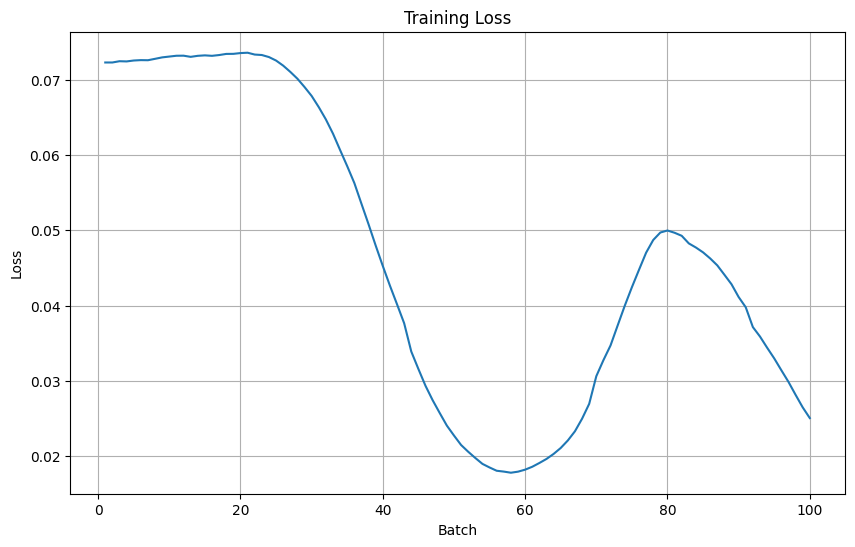

In [47]:
logger.data['metrics/eval/MaskedAccuracy']
import matplotlib.pyplot as plt

# Extract time and loss values
time_values = []
loss_values = []
for t, v in logger.data['metrics/eval/MaskedAccuracy']:
    time_values.append(t.batch.value)
    loss_values.append(v.cpu())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_values, loss_values)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)


In [ ]:
metrics[0].sum_loss

In [ ]:
!ls training/pretrain/

In [ ]:
from composer.optim import DecoupledAdamW, CosineAnnealingWithWarmupScheduler
from composer.loggers import InMemoryLogger
from composer.metrics import MaskedAccuracy

optim = DecoupledAdamW(my_model.parameters(), lr=2e-4, weight_decay=0.0001)
lr_scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='200ba', t_max="1dur")

logger = InMemoryLogger()

trainer = Trainer(
    model=my_model,
    train_dataloader=dl_train, 
    eval_dataloader=eval_evaluator,
    optimizers=optim,
    schedulers=lr_scheduler,
    max_duration="2ep",
    eval_interval='1000ba',
    save_folder="training/pretrain/compile/" + str(optim.param_groups[0]['lr']),
    save_interval="5000ba",
    save_filename="hf_model.pt",
    save_overwrite=True,
    device_train_microbatch_size='auto',
    loggers=logger,
    device='gpu',
    precision='amp_bf16',
    autoresume=True,
)